# Tutorial 11-3: The Odd One Out – "Anomaly Detection with Autoencoders"

**Course:** CSEN 342: Deep Learning  
**Topic:** Unsupervised Learning, Autoencoders, and Outlier Detection

## Objective
As discussed in the lecture (Slide 7), Autoencoders force data into a "narrow" distribution. We can exploit this for **Anomaly Detection**.

**The Hypothesis:** If an Autoencoder is trained *only* on normal data, it will learn to reconstruct normal data very well (Low Error). However, when it encounters an anomaly it has never seen, it will fail to reconstruct it (High Error).

In this tutorial, we will:
1.  **Filter Data:** Create a dataset containing only the digit "1" (Normal).
2.  **Train:** Teach an Autoencoder to reconstruct "1"s perfectly.
3.  **Test:** Feed it "7"s (Anomalies) and measure the reconstruction error.
4.  **Detect:** Use the error score to separate Normal from Anomaly.

---

## Part 1: Data Preparation

We need to manually filter the MNIST dataset. 
* **Train Set:** Only 1s.
* **Test Set:** A mix of 1s (Normal) and 7s (Anomaly).

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os

# 1. Load MNIST
data_root = '../data'
os.makedirs(data_root, exist_ok=True)
transform = transforms.Compose([transforms.ToTensor()])

train_full = torchvision.datasets.MNIST(root=data_root, train=True, download=True, transform=transform)
test_full = torchvision.datasets.MNIST(root=data_root, train=False, download=True, transform=transform)

# 2. Filter Function
def filter_class(dataset, class_label):
    indices = [i for i, (img, label) in enumerate(dataset) if label == class_label]
    return Subset(dataset, indices)

# Train only on 1s
train_normal = filter_class(train_full, 1)

# Test on 1s (Normal) and 7s (Anomaly)
test_normal = filter_class(test_full, 1)
test_anomaly = filter_class(test_full, 7)

train_loader = DataLoader(train_normal, batch_size=64, shuffle=True)
test_normal_loader = DataLoader(test_normal, batch_size=1000)
test_anomaly_loader = DataLoader(test_anomaly, batch_size=1000)

print(f"Training samples (1s): {len(train_normal)}")
print(f"Test Normal (1s): {len(test_normal)}")
print(f"Test Anomaly (7s): {len(test_anomaly)}")

Training samples (1s): 6742
Test Normal (1s): 1135
Test Anomaly (7s): 1028


---

## Part 2: The Constrained Autoencoder

We use a simple Linear Autoencoder. 
We set the **bottleneck size to 2**. This forces the network to learn a very compressed 2D representation of the number "1". It won't have enough "memory" to memorize random noise or other shapes.

In [4]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder: 784 -> 64 -> 2
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 64),
            nn.ReLU(),
            nn.Linear(64, 2) # Tight bottleneck
        )
        # Decoder: 2 -> 64 -> 784
        self.decoder = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 28*28),
            nn.Sigmoid() # Output [0, 1]
        )

    def forward(self, x):
        x = x.view(-1, 28*28)
        latent = self.encoder(x)
        recon = self.decoder(latent)
        return recon.view(-1, 1, 28, 28)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder().to(device)
criterion = nn.MSELoss()

---

## Part 3: Training (Learning "Normalcy")

We train the model solely on the "1"s. It will become an expert at drawing ones.

In [5]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 10

print("Training on Normal data (1s)...")
for epoch in range(epochs):
    train_loss = 0
    for imgs, _ in train_loader:
        imgs = imgs.to(device)
        
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, imgs)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    print(f"Epoch {epoch+1}, Loss: {train_loss/len(train_loader):.4f}")

Training on Normal data (1s)...
Epoch 1, Loss: 0.0732
Epoch 2, Loss: 0.0282
Epoch 3, Loss: 0.0162
Epoch 4, Loss: 0.0126
Epoch 5, Loss: 0.0122
Epoch 6, Loss: 0.0119
Epoch 7, Loss: 0.0118
Epoch 8, Loss: 0.0115
Epoch 9, Loss: 0.0113
Epoch 10, Loss: 0.0111


---

## Part 4: Anomaly Detection (The Histogram)

Now we feed it both Normal (1s) and Anomalous (7s) data. We calculate the reconstruction loss for *each individual image*. 

We expect the loss for 1s to be low, and the loss for 7s to be high.

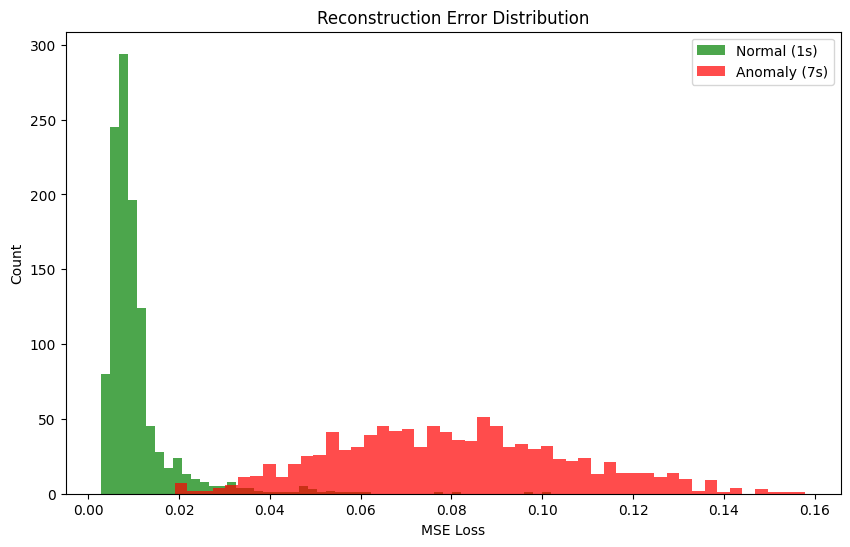

In [6]:
def get_losses(loader, model):
    losses = []
    model.eval()
    with torch.no_grad():
        for imgs, _ in loader:
            imgs = imgs.to(device)
            outputs = model(imgs)
            
            # Calculate MSE per image (keep batch dimension)
            # (Batch, 1, 28, 28) -> (Batch, 784)
            loss = torch.mean((imgs - outputs)**2, dim=[1, 2, 3])
            losses.extend(loss.cpu().numpy())
    return losses

normal_losses = get_losses(test_normal_loader, model)
anomaly_losses = get_losses(test_anomaly_loader, model)

plt.figure(figsize=(10, 6))
plt.hist(normal_losses, bins=50, alpha=0.7, label='Normal (1s)', color='green')
plt.hist(anomaly_losses, bins=50, alpha=0.7, label='Anomaly (7s)', color='red')
plt.title("Reconstruction Error Distribution")
plt.xlabel("MSE Loss")
plt.ylabel("Count")
plt.legend()
plt.show()

### Visual Proof
Let's see *why* the error is high for the 7. What does the model try to draw when given a 7?

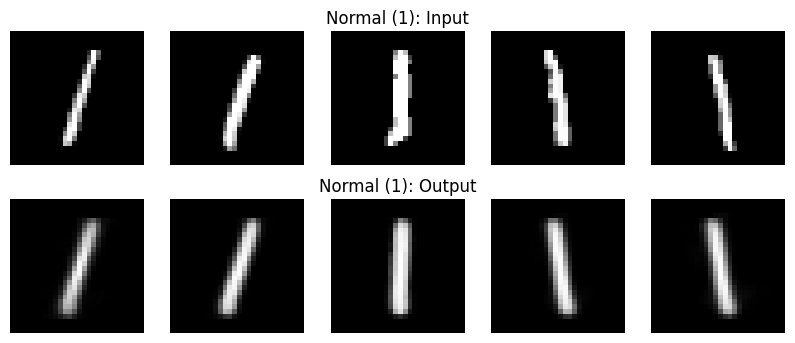

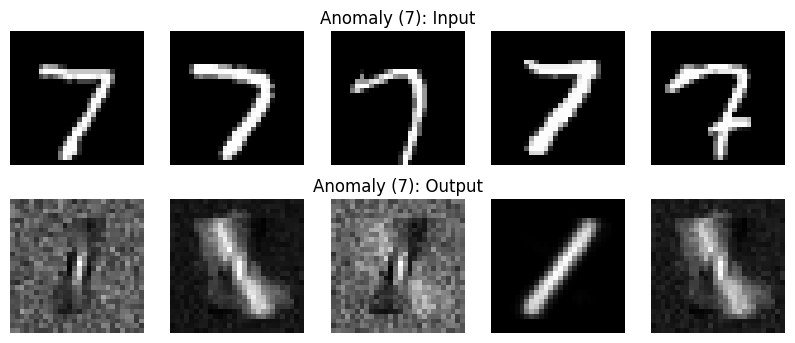

In [7]:
def visualize_reconstruction(loader, title):
    imgs, _ = next(iter(loader))
    imgs = imgs[:5].to(device)
    with torch.no_grad():
        recon = model(imgs)
    
    imgs = imgs.cpu()
    recon = recon.cpu()
    
    plt.figure(figsize=(10, 4))
    for i in range(5):
        # Original
        plt.subplot(2, 5, i + 1)
        plt.imshow(imgs[i].squeeze(), cmap='gray')
        if i == 2: plt.title(f"{title}: Input")
        plt.axis('off')
        
        # Reconstruction
        plt.subplot(2, 5, i + 6)
        plt.imshow(recon[i].squeeze(), cmap='gray')
        if i == 2: plt.title(f"{title}: Output")
        plt.axis('off')
    plt.show()

visualize_reconstruction(test_normal_loader, "Normal (1)")
visualize_reconstruction(test_anomaly_loader, "Anomaly (7)")

### Conclusion

**Interpretation:**
Look at the output for the "7". The model likely tried to draw a "1" that roughly matches the position of the "7", or just a blurry blob. It failed to capture the horizontal bar of the 7. 

This failure is exactly what we want! The high pixel difference between the input "7" and the output "blob" creates the high loss score that flags it as an anomaly.

**Real-World Use:**
This technique is used to detect:
* **Credit Card Fraud:** Train on valid transactions; fraudulent ones will have high reconstruction error.
* **Manufacturing Defects:** Train on pictures of good parts; broken parts will have high error.
* **Network Intrusions:** Train on normal traffic patterns.